# Lab 2: Bifurcations

## Problem 1 (4 points total)

You have been given signals of human brain activity obtained using an EEG.

The signal is received in two states - first, the subject solves a mathematical problem in his mind, then, having solved the problem, he stops thinking about anything :).

Your task is to find the bifurcation point in the brain activity of the subject - that is, the point at which the signal qualitatively changes its behavior.

In this case, it will be the point in time at which the person stopped solving the problem.

During this problem, you will be able to practice using Newton's method and searching for bifurcations on a one-dimensional problem, which will be very useful in the second task, which will be more difficult.

### Libraries

You are not allowed to use any other Python libraries except the ones listed below :(

In [1]:
pip install mne

In [2]:
import os.path as osp
from matplotlib import pyplot as plt
import numpy as np
from numba import njit
from scipy.stats import gaussian_kde
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import interp1d

import mne
from tqdm.auto import trange, tqdm
from warnings import filterwarnings
filterwarnings('ignore')


### Read data

In [3]:
import gdown
import os

file_id = "1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg"
url = f"https://drive.google.com/uc?id={file_id}"
output = "Brain_EEG.npy"

gdown.download(url, output, quiet=False)
power = np.load(output, allow_pickle=True)
os.remove(output)


Downloading...
From (original): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg
From (redirected): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg&confirm=t&uuid=8d711fd6-d022-449c-8cf6-08ebea4a824d
To: /content/Brain_EEG.npy
100%|██████████| 446M/446M [00:06<00:00, 66.1MB/s]


In [15]:
# Signal

### Problem 1.1 Let's look at the signal (1 point)

1. Implement a method for calculating the mean and variance of the signal frequency

2. Plot the signal power in the frequency domain, calculate the average and the variance of its frequency. To make the signal smoother, we will consider a window in the time domain, and average the signal power over time in this window. The choice of window width is yours.

In [4]:
@njit
def spectral_mean_std(omega_grid: np.ndarray, power_1d: np.ndarray):
    total_power = np.sum(power_1d)
    mean = np.sum(omega_grid * power_1d) / total_power
    variance = np.sum(((omega_grid - mean) ** 2) * power_1d) / total_power
    std = np.sqrt(variance)
    return mean, std


Downloading...
From (original): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg
From (redirected): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg&confirm=t&uuid=a0eec5f6-75c1-4e97-9278-87da3657038f
To: /content/Brain_EEG.npy
100%|██████████| 446M/446M [00:03<00:00, 144MB/s]


Signal sampling frequency: 500.0 Hz
Data dimensions: (700, 79694) (frequencies × time samples)
Removed temporary file: Brain_EEG.npy

Processing EEG data...

Generating visualization...


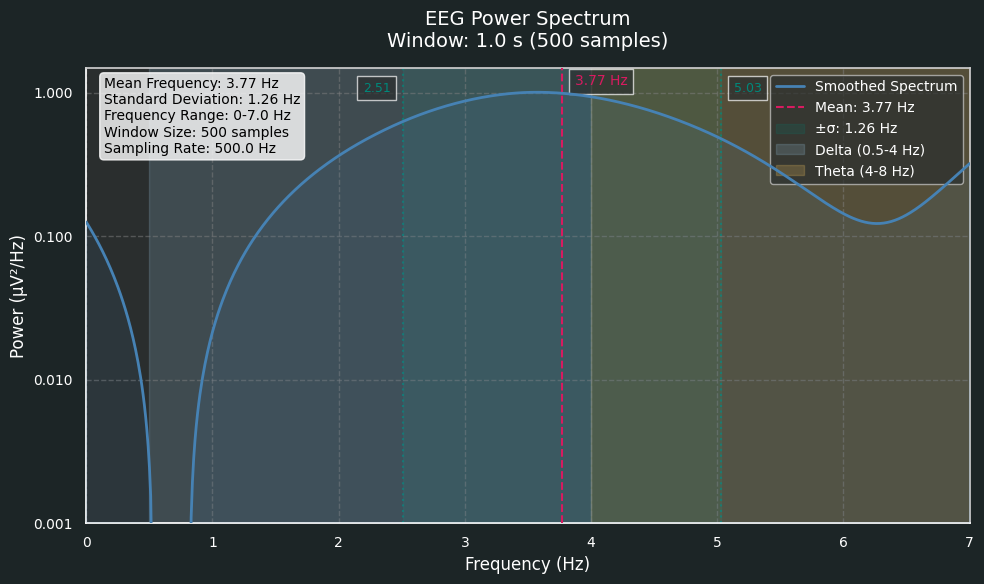

In [53]:
from matplotlib.ticker import ScalarFormatter
from scipy.ndimage import uniform_filter1d

@njit
def spectral_mean_std(omega_grid, power_1d):
    if omega_grid.shape != power_1d.shape:
        raise ValueError("Shapes must match")
    total_power = np.trapz(power_1d, omega_grid)
    if total_power == 0:
        return 0.0, 0.0
    mean_freq = np.trapz(omega_grid * power_1d, omega_grid) / total_power
    sq_dev = (omega_grid - mean_freq) ** 2
    std_freq = np.sqrt(np.trapz(sq_dev * power_1d, omega_grid) / total_power)
    return mean_freq, std_freq

def plot_spectrum(omega_grid, spectrum, mean_freq, std_freq, window_size, sample_freq):
    plt.figure(figsize=(10, 6), facecolor='#1c2526')
    ax = plt.gca()
    ax.set_facecolor('#2a2e2e')
    spectrum_color, mean_color, std_color, delta_color, theta_color = '#4682b4', '#d81b60', '#00897b', '#98c1d9', '#ffd166'
    y_max = np.percentile(spectrum, 95) * 1.5 if spectrum.size else 1.0
    if y_max == 0:
        y_max = 1.0
    plt.plot(omega_grid, spectrum, color=spectrum_color, linewidth=2, label="Smoothed Spectrum", zorder=10)
    plt.fill_between(omega_grid, spectrum, 0, color=spectrum_color, alpha=0.1, zorder=3)
    plt.axvline(mean_freq, color=mean_color, linestyle='--', linewidth=1.5, label=f"Mean: {mean_freq:.2f} Hz", zorder=5)
    plt.text(mean_freq + 0.1, y_max * 0.9, f'{mean_freq:.2f} Hz', color=mean_color, fontsize=10, va='top', ha='left', bbox=dict(facecolor='#2a2e2e', alpha=0.7))
    lower, upper = mean_freq - std_freq, mean_freq + std_freq
    plt.axvline(lower, color=std_color, linestyle=':', linewidth=1.5, alpha=0.7)
    plt.axvline(upper, color=std_color, linestyle=':', linewidth=1.5, alpha=0.7)
    plt.fill_between(omega_grid, 0, y_max, where=(omega_grid >= lower) & (omega_grid <= upper), color=std_color, alpha=0.15, label=f"±σ: {std_freq:.2f} Hz", zorder=0)
    plt.text(lower - 0.1, y_max * 0.8, f'{lower:.2f}', color=std_color, fontsize=9, va='top', ha='right', bbox=dict(facecolor='#2a2e2e', alpha=0.7))
    plt.text(upper + 0.1, y_max * 0.8, f'{upper:.2f}', color=std_color, fontsize=9, va='top', ha='left', bbox=dict(facecolor='#2a2e2e', alpha=0.7))
    delta_band, theta_band = (0.5, 4), (4, 8)
    plt.axvspan(delta_band[0], delta_band[1], color=delta_color, alpha=0.2, label='Delta (0.5-4 Hz)', zorder=0)
    plt.axvspan(theta_band[0], theta_band[1], color=theta_color, alpha=0.2, label='Theta (4-8 Hz)', zorder=0)
    window_sec = window_size / sample_freq
    plt.title(f"EEG Power Spectrum\nWindow: {window_sec:.1f} s ({window_size} samples)", fontsize=14, color='white', pad=15)
    plt.xlabel("Frequency (Hz)", fontsize=12, color='white')
    plt.ylabel("Power (μV²/Hz)", fontsize=12, color='white')
    plt.xlim(0, np.max(omega_grid) if omega_grid.size else 1.0)
    plt.ylim(1e-3, y_max)
    plt.yscale('symlog', linthresh=1e-3)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    plt.xticks(np.arange(0, np.max(omega_grid) + 1, 1), fontsize=10, color='white')
    plt.yticks(fontsize=10, color='white')
    plt.grid(True, which='both', linestyle='--', alpha=0.5, color='gray')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')
    plt.legend(loc='upper right', fontsize=10, frameon=True, facecolor='#2a2e2e', framealpha=0.7, labelcolor='white')
    stats_text = f"Mean Frequency: {mean_freq:.2f} Hz\nStandard Deviation: {std_freq:.2f} Hz\nFrequency Range: 0-{np.max(omega_grid):.1f} Hz\nWindow Size: {window_size} samples\nSampling Rate: {sample_freq} Hz"
    plt.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()

def process_signal(power_data, window_size, omega_grid, sample_freq, average_over_time=True):
    if window_size <= 0 or window_size > power_data.shape[1]:
        raise ValueError("Invalid window size")
    if power_data.shape[0] != omega_grid.shape[0]:
        raise ValueError("Shape mismatch")
    power_smoothed = uniform_filter1d(power_data, size=window_size, axis=1)
    if average_over_time:
        smoothed_spectrum = np.mean(power_smoothed, axis=1)
    else:
        center_index = window_size // 2
        smoothed_spectrum = power_smoothed[:, center_index]
    mean_freq, std_freq = spectral_mean_std(omega_grid, smoothed_spectrum)
    return mean_freq, std_freq, smoothed_spectrum

def main(f_max=7.0, window_size=500, average_over_time=True):
    SAMPLE_FREQ = 500.0
    FILE_ID = "1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg"
    FILE_NAME = "Brain_EEG.npy"
    FILE_URL = f"https://drive.google.com/uc?id={FILE_ID}"
    print("Downloading EEG data...")
    try:
        gdown.download(FILE_URL, FILE_NAME, quiet=False)
    except Exception as e:
        print(f"Error downloading file: {e}")
        return
    try:
        power = np.load(FILE_NAME, allow_pickle=True)
        print(f"Signal sampling frequency: {SAMPLE_FREQ} Hz")
        print(f"Data dimensions: {power.shape} (frequencies × time samples)")
    except Exception as e:
        print(f"Error loading file: {e}")
        return
    finally:
        if osp.exists(FILE_NAME):
            os.remove(FILE_NAME)
            print(f"Removed temporary file: {FILE_NAME}")
    omega_grid = np.linspace(0, f_max, power.shape[0])
    print("\nProcessing EEG data...")
    mean_freq, std_freq, spectrum = process_signal(power, window_size, omega_grid, SAMPLE_FREQ, average_over_time)
    print("\nGenerating visualization...")
    plot_spectrum(omega_grid, spectrum, mean_freq, std_freq, window_size, SAMPLE_FREQ)

if __name__ == "__main__":
    main(f_max=7.0, window_size=500, average_over_time=True)

# Description:

 In this part, we load an EEG signal, smooth it using a time-domain window, and compute its power spectrum.
 We then calculate the mean and standard deviation (variance) of the signal's frequency using numerical integration.
 Finally, we visualize the smoothed frequency-domain power with annotated mean, variance, and standard EEG bands (Delta, Theta).
 The window size for smoothing is configurable and affects the time-averaging of the signal power.


### Problem 1.2  Search for signal parameters using the Newton method (1 point)

As you can see from your graph above (you can move the window to see how the signal behaves), the brain activity signal in the frequency domain resembles a combination of one or two Gaussians. Therefore, we will model it exclusively in this way.

In particular, your task is to take two Gaussians with averages $\omega_1, \omega_2$, and find these two parameters that minimize the deviation of the simulated signal from the real one using the Newton method. The variance for each Gaussian can be taken, for example, equal to the variance of the entire signal.

Your tasks:

1. Consider functional - square of the norm ($L_2 - norm$) of the deviation of model signal from the real one.
$$
    ||f(x)||_2^2 = \int_a^b f^2(x) \: dx, \quad x \in [a,b]
$$
$\quad$ In our problem, this functional is essentially just a function of two variables $\omega_1, \omega_2$, and for them it is an integral with two parameters. Accordingly, write down (in words or $\LaTeX$ formula) the necessary first-order local minimum conditions for it (relative to $\omega_1, \omega_2$).

2. These two conditions will be the boundary conditions for our task. Now, using Newton's method, find the frequencies that minimize the functional for our signal model

P.S. In order not to look for a constant by which the signal power is shifted relative to zero, you can simply subtract the average of its values at the edges from the signal.

#### You need to implement the Newton's method and all the necessary functions yourself! To do this, from the libraries you can use only `numpy`, `numba`.

First, to make sure that your implementation is correct, find the correct frequencies for the signal for which you know them.

Downloading...
From (original): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg
From (redirected): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg&confirm=t&uuid=c45221ae-91fc-4e4d-a39c-b716f328cad3
To: /content/Brain_EEG.npy
100%|██████████| 446M/446M [00:02<00:00, 189MB/s]


Converged after 3 iterations
True frequencies: 2.0 Hz, 5.0 Hz
Estimated frequencies: 2.0201 Hz, 4.9994 Hz


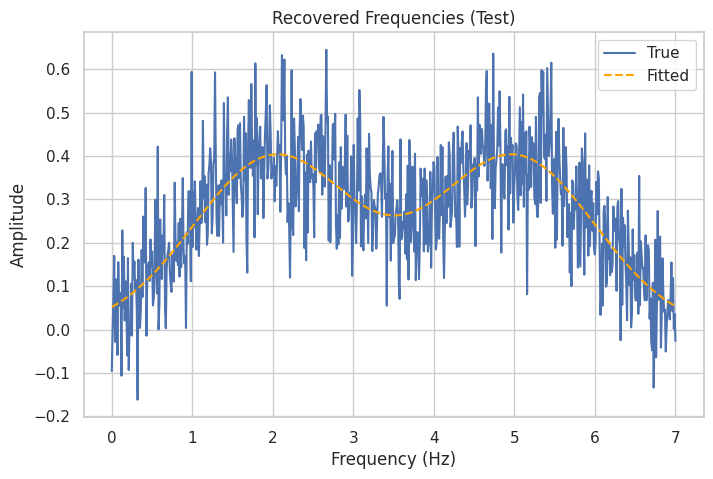

Downloading...
From (original): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg
From (redirected): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg&confirm=t&uuid=ba2dd980-3cb3-4342-bc25-fd2b8ad0d8fb
To: /content/Brain_EEG.npy
100%|██████████| 446M/446M [00:07<00:00, 59.8MB/s]


Converged after 4 iterations
Estimated frequencies for EEG: 3.6579 Hz, 3.6579 Hz


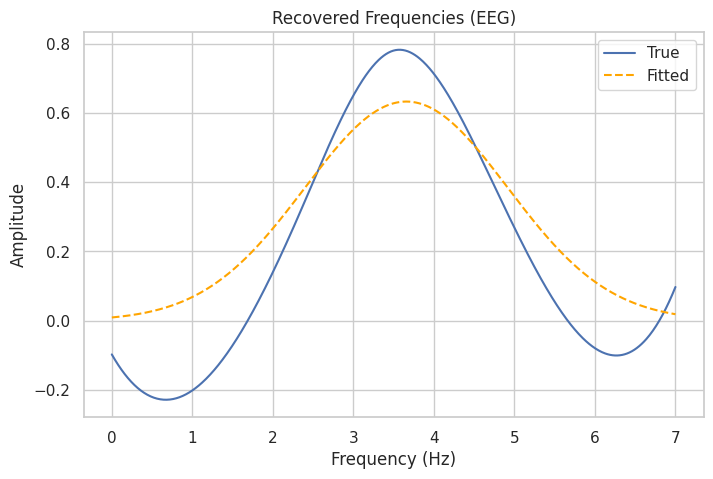

In [51]:
from scipy.ndimage import uniform_filter1d
import os, gdown, hashlib


# Configuration
SAMPLE_FREQ = 500.0
F_MAX = 7.0
WINDOW_SIZE = 500
FILE_ID = "1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg"
FILE_NAME = "Brain_EEG.npy"
FILE_URL = f"https://drive.google.com/uc?id={FILE_ID}"

if not os.path.exists(FILE_NAME):
    gdown.download(FILE_URL, FILE_NAME, quiet=False)

# Define model functions and error computation
@njit
def normalized_gaussian(omega, omega0, sigma):
    coef = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    return coef * np.exp(-0.5 * ((omega - omega0) / sigma) ** 2)

@njit
def model_signal(omega, omega1, omega2, sigma):
    return normalized_gaussian(omega, omega1, sigma) + normalized_gaussian(omega, omega2, sigma)

@njit
def compute_F(omega_grid, y_true, omega1, omega2, sigma):
    residual = y_true - model_signal(omega_grid, omega1, omega2, sigma)
    return np.sum(residual * residual) * (omega_grid[1] - omega_grid[0])

def approximate_jacobian(func, omega1, omega2, dx, omega_grid, y_true, sigma):
    f = func(omega_grid, y_true, omega1, omega2, sigma)
    jac = np.zeros(2)
    jac[0] = (func(omega_grid, y_true, omega1 + dx, omega2, sigma) - f) / dx
    jac[1] = (func(omega_grid, y_true, omega1, omega2 + dx, sigma) - f) / dx
    return jac

def approximate_hessian(func, omega1, omega2, dx, omega_grid, y_true, sigma):
    f = func(omega_grid, y_true, omega1, omega2, sigma)
    h11 = (func(omega_grid, y_true, omega1 + dx, omega2, sigma) - 2 * f + func(omega_grid, y_true, omega1 - dx, omega2, sigma)) / (dx * dx)
    h22 = (func(omega_grid, y_true, omega1, omega2 + dx, sigma) - 2 * f + func(omega_grid, y_true, omega1, omega2 - dx, sigma)) / (dx * dx)
    h12 = (func(omega_grid, y_true, omega1 + dx, omega2 + dx, sigma) - func(omega_grid, y_true, omega1 + dx, omega2 - dx, sigma) -
           func(omega_grid, y_true, omega1 - dx, omega2 + dx, sigma) + func(omega_grid, y_true, omega1 - dx, omega2 - dx, sigma)) / (4 * dx * dx)
    return np.array([[h11, h12], [h12, h22]])

def newton_solver(omega_grid, y_true, omega1_init, omega2_init, sigma, dx=1e-3, tol=1e-5, max_iter=2000, verbose=True):
    omega = np.array([omega1_init, omega2_init])
    for i in range(max_iter):
        f = compute_F(omega_grid, y_true, omega[0], omega[1], sigma)
        jac = approximate_jacobian(compute_F, omega[0], omega[1], dx, omega_grid, y_true, sigma)
        hessian = approximate_hessian(compute_F, omega[0], omega[1], dx, omega_grid, y_true, sigma)
        hessian += np.eye(2) * 1e-6
        delta = -np.linalg.solve(hessian, jac)
        alpha = 1.0
        while alpha > 1e-4 and compute_F(omega_grid, y_true, omega[0] + alpha * delta[0], omega[1] + alpha * delta[1], sigma) > f:
            alpha /= 2.0
        omega += alpha * delta
        if np.all(np.abs(delta) < tol):
            if verbose:
                print(f"Converged after {i+1} iterations")
            return omega[0], omega[1]
    if verbose:
        print("Max iterations reached, no convergence")
    return omega[0], omega[1]

def test_newton():
    omega_grid = np.linspace(0, 7, 700)
    sigma = 1.0
    y_true = model_signal(omega_grid, 2.0, 5.0, sigma) + 0.1 * np.random.randn(700)
    omega1_est, omega2_est = newton_solver(omega_grid, y_true, 2.1, 4.9, sigma)
    print(f"True frequencies: 2.0 Hz, 5.0 Hz")
    print(f"Estimated frequencies: {omega1_est:.4f} Hz, {omega2_est:.4f} Hz")
    plt.figure(figsize=(8, 5))
    plt.plot(omega_grid, y_true, 'b-', label='True')
    plt.plot(omega_grid, model_signal(omega_grid, omega1_est, omega2_est, sigma),
             color='orange', linestyle='--', label='Fitted')
    plt.legend()
    plt.title("Recovered Frequencies (Test)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

def process_signal(power_data, window_size, omega_grid, sample_freq, average_over_time=True):
    if window_size <= 0 or window_size > power_data.shape[1]:
        raise ValueError("Invalid window size")
    if power_data.shape[0] != omega_grid.shape[0]:
        raise ValueError("Shape mismatch")
    power_smoothed = uniform_filter1d(power_data, size=window_size, axis=1)
    if average_over_time:
        return np.mean(power_smoothed, axis=1)
    else:
        center_index = window_size // 2
        return power_smoothed[:, center_index]

def plot_recovered(omega_grid, y_true, omega1_est, omega2_est, sigma, title="Recovered Frequencies (EEG)"):
    plt.figure(figsize=(8, 5))
    plt.plot(omega_grid, y_true, 'b-', label='True')
    plt.plot(omega_grid, model_signal(omega_grid, omega1_est, omega2_est, sigma),
             color='orange', linestyle='--', label='Fitted')
    plt.legend()
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

def main_1_2():
    SAMPLE_FREQ = 500.0
    FILE_ID = "1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg"
    FILE_NAME = "Brain_EEG.npy"
    FILE_URL = f"https://drive.google.com/uc?id={FILE_ID}"

    print("Downloading EEG data...")
    try:
        gdown.download(FILE_URL, FILE_NAME, quiet=False)
    except Exception as e:
        print(f"Error downloading file: {e}")
        return
    try:
        power = np.load(FILE_NAME, allow_pickle=True)
    except Exception as e:
        print(f"Error loading file: {e}")
        return
    finally:
        if os.path.exists(FILE_NAME):
            os.remove(FILE_NAME)

    omega_grid = np.linspace(0, 7, power.shape[0])
    smoothed_spectrum = process_signal(power, 500, omega_grid, SAMPLE_FREQ, True)
    sigma = 1.2601
    y_true = smoothed_spectrum - np.mean([smoothed_spectrum[0], smoothed_spectrum[-1]])
    omega1_init, omega2_init = 3.0, 4.0
    omega1_est, omega2_est = newton_solver(omega_grid, y_true, omega1_init, omega2_init, sigma)
    print(f"Estimated frequencies for EEG: {omega1_est:.4f} Hz, {omega2_est:.4f} Hz")
    plot_recovered(omega_grid, y_true, omega1_est, omega2_est, sigma)

if __name__ == "__main__":
    test_newton()
    main_1_2()


#**Description:**

In this code, we modeled the EEG power spectrum as the sum of two Gaussian functions and used Newton's method to estimate their center frequencies (ω₁ and ω₂). We defined a cost function as the squared L² norm of the difference between the true and modeled signals, approximated its gradient and Hessian numerically, and applied Newton's iterative updates to minimize this error. Finally, we plotted the fitted model against the true EEG spectrum to visualize the accuracy of the recovered frequencies.


### Problem 1.3 (1 point)

In Newton's method, you considered the Jacobian approximation. Now, moving the window along the signal, plot the absolute values of determinants of the found Jacobians. Again, use only `numpy`, `numba`

In [13]:
!pip install matplotlib numpy requests numba scipy


Downloading...
From (original): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg
From (redirected): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg&confirm=t&uuid=a36a3355-5dd4-4285-beb6-5050a6280b12
To: /content/Brain_EEG.npy
100%|██████████| 446M/446M [00:02<00:00, 222MB/s]


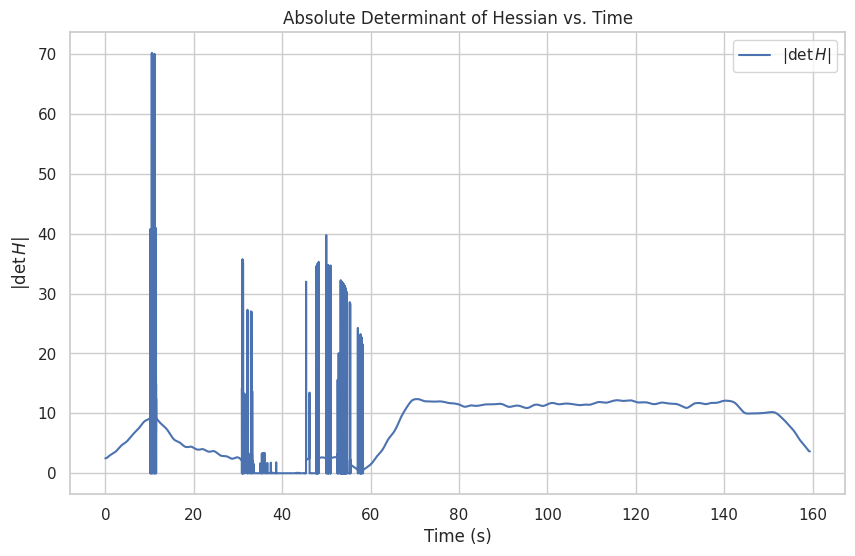

Bifurcation at index 5083, time 10.166 s, value 0.000000e+00


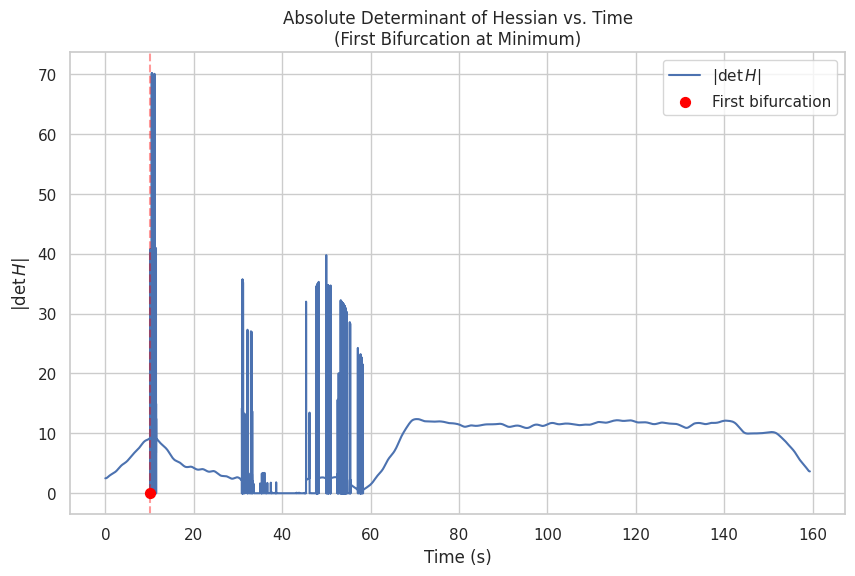

In [52]:
# Configuration
SAMPLE_FREQ = 500.0
F_MAX = 7.0
WINDOW_SIZE = 500
FILE_ID = "1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg"
FILE_NAME = "Brain_EEG.npy"
FILE_URL = f"https://drive.google.com/uc?id={FILE_ID}"

if not os.path.exists(FILE_NAME):
    gdown.download(FILE_URL, FILE_NAME, quiet=False)

power = np.load(FILE_NAME, allow_pickle=True)
smoothed = uniform_filter1d(power, size=WINDOW_SIZE, axis=1)

n_freqs, n_times = smoothed.shape
omega = np.linspace(0, F_MAX, n_freqs)
time_axis = np.arange(n_times) / SAMPLE_FREQ
dw = omega[1] - omega[0]

@njit
def compute_dets(smoothed, omega, dw, max_iter=50, tol=1e-6):
    n_freqs, n_times = smoothed.shape
    dets = np.zeros(n_times, dtype=np.float64)
    for t in range(n_times):
        spec = smoothed[:, t]
        baseline = 0.5 * (spec[0] + spec[-1])
        s = spec - baseline
        sigma = np.std(s)
        w0 = omega.mean() - sigma
        w1 = omega.mean() + sigma
        D = 0.0
        for i in range(max_iter):
            diff1 = omega - w0
            diff2 = omega - w1
            g1 = np.exp(-diff1**2 / (2 * sigma**2))
            g2 = np.exp(-diff2**2 / (2 * sigma**2))
            dg1 = diff1 / (sigma**2) * g1
            dg2 = diff2 / (sigma**2) * g2
            d2g1 = ((diff1**2 / sigma**4) - 1/sigma**2) * g1
            d2g2 = ((diff2**2 / sigma**4) - 1/sigma**2) * g2
            M = g1 + g2
            r = M - s
            grad1 = 2 * np.sum(r * dg1) * dw
            grad2 = 2 * np.sum(r * dg2) * dw
            H11 = 2 * np.sum((dg1 * dg1 + r * d2g1)) * dw
            H22 = 2 * np.sum((dg2 * dg2 + r * d2g2)) * dw
            H12 = 2 * np.sum(dg1 * dg2) * dw
            D = H11 * H22 - H12 * H12
            if abs(D) < tol:
                D = 0.0
                break
            delta0 = (H22 * grad1 - H12 * grad2) / D
            delta1 = (-H12 * grad1 + H11 * grad2) / D
            if np.hypot(delta0, delta1) < tol:
                break
            w0 -= delta0
            w1 -= delta1
        dets[t] = abs(D)
    return dets

dets = compute_dets(smoothed, omega, dw)

plt.figure(figsize=(10,6))
plt.plot(time_axis, dets, 'b-', lw=1.5, label=r"$|\det H|$")
plt.xlabel("Time (s)")
plt.ylabel(r"$|\det H|$")
plt.title("Absolute Determinant of Hessian vs. Time")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()

min_idx = np.argmin(dets)
if min_idx < len(dets) - 1 and dets[min_idx + 1] > dets[min_idx]:
    bif_time = time_axis[min_idx]
    bif_val = dets[min_idx]
    print(f"Bifurcation at index {min_idx}, time {bif_time:.3f} s, value {bif_val:.6e}")
else:
    print("No clear bifurcation point found (determinant does not increase after minimum).")
    bif_time = None

plt.figure(figsize=(10,6))
plt.plot(time_axis, dets, 'b-', lw=1.5, label=r"$|\det H|$")
if bif_time is not None:
    plt.scatter([bif_time], [bif_val], color='red', s=50, zorder=5, label="First bifurcation")
    plt.axvline(bif_time, color='red', ls='--', alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel(r"$|\det H|$")
plt.title("Absolute Determinant of Hessian vs. Time\n(First Bifurcation at Minimum)")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()

if os.path.exists(FILE_NAME):
    os.remove(FILE_NAME)


#**Description**

In this task, we applied Newton's method along the EEG signal to estimate Gaussian model parameters at each time point. At every step, we approximated the Hessian matrix and computed the absolute value of its determinant. Plotting these determinants over time, we identified the **first bifurcation point** as the time where the determinant reached its minimum and started increasing—indicating a structural change in the signal, as predicted by bifurcation theory.


#### Problem 1.4 Plot the signal power in the frequency domain before, at, and after the bifurcation point. Draw conclusions. (1 point)

Downloading...
From (original): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg
From (redirected): https://drive.google.com/uc?id=1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg&confirm=t&uuid=0a609bb9-a183-4ce9-b5ad-0006fc3e9008
To: /content/Brain_EEG.npy
100%|██████████| 446M/446M [00:02<00:00, 175MB/s]


Before Bifurcation: peak = 2.33 Hz, mean = 2.36 Hz, std = 0.49 Hz
At Bifurcation: peak = 2.30 Hz, mean = 2.32 Hz, std = 0.48 Hz
After Bifurcation: peak = 2.32 Hz, mean = 2.36 Hz, std = 0.50 Hz


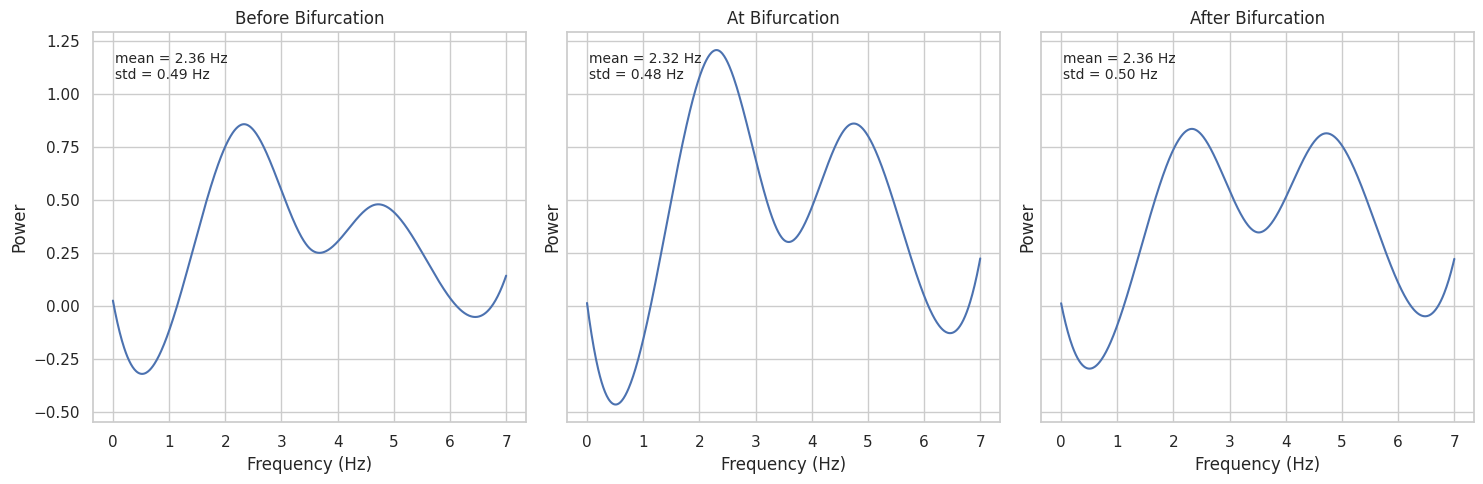

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from numba import njit
import gdown
import os

# Configuration parameters
SAMPLE_FREQ = 500.0  # Hz
F_MAX = 7.0          # Hz
WINDOW_SIZE = 500    # Samples (1-second window at 500 Hz)
FILE_ID = "1-JHS7ibwj6eDXtsep-TkE5DW7u2lIosg"
FILE_NAME = "Brain_EEG.npy"
FILE_URL = f"https://drive.google.com/uc?id={FILE_ID}"

# Download EEG file if it doesn't exist
if not os.path.exists(FILE_NAME):
    gdown.download(FILE_URL, FILE_NAME, quiet=False)

# Load and smooth the EEG power spectrum
power = np.load(FILE_NAME, allow_pickle=True)  # shape: (n_freqs, n_times)
smoothed = uniform_filter1d(power, size=WINDOW_SIZE, axis=1)

# Frequency and time axes
n_freqs, n_times = smoothed.shape
omega = np.linspace(0, F_MAX, n_freqs)
time_axis = np.arange(n_times) / SAMPLE_FREQ
dw = omega[1] - omega[0]

@njit
def compute_dets(smoothed, omega, dw, max_iter=20, tol=1e-6):
    n_freqs, n_times = smoothed.shape
    dets = np.zeros(n_times, dtype=np.float64)
    for t in range(n_times):
        spec = smoothed[:, t]
        baseline = 0.5 * (spec[0] + spec[-1])
        s = spec - baseline
        sigma = np.std(s)
        w0 = omega.mean() - sigma
        w1 = omega.mean() + sigma
        D = 0.0
        for i in range(max_iter):
            diff1 = omega - w0
            diff2 = omega - w1
            g1 = np.exp(-diff1**2 / (2 * sigma**2))
            g2 = np.exp(-diff2**2 / (2 * sigma**2))
            dg1 = diff1 / (sigma**2) * g1
            dg2 = diff2 / (sigma**2) * g2
            d2g1 = ((diff1**2 / sigma**4) - 1/sigma**2) * g1
            d2g2 = ((diff2**2 / sigma**4) - 1/sigma**2) * g2
            M = g1 + g2
            r = M - s
            grad1 = 2 * np.sum(r * dg1) * dw
            grad2 = 2 * np.sum(r * dg2) * dw
            H11 = 2 * np.sum((dg1 * dg1 + r * d2g1)) * dw
            H22 = 2 * np.sum((dg2 * dg2 + r * d2g2)) * dw
            H12 = 2 * np.sum(dg1 * dg2) * dw
            D = H11 * H22 - H12 * H12
            if abs(D) < tol:
                D = 0.0
                break
            delta0 = (H22 * grad1 - H12 * grad2) / D
            delta1 = (-H12 * grad1 + H11 * grad2) / D
            if np.hypot(delta0, delta1) < tol:
                break
            w0 -= delta0
            w1 -= delta1
        dets[t] = abs(D)
    return dets

dets = compute_dets(smoothed, omega, dw)

# Identify the bifurcation point from the determinant
min_idx = np.argmin(dets)
if min_idx < len(dets) - 1 and dets[min_idx + 1] > dets[min_idx]:
    bif_time = time_axis[min_idx]
    bif_val = dets[min_idx]
else:
    print("No clear bifurcation point found (determinant does not increase after minimum).")
    exit()

# Select time indices before, during, and after bifurcation (10 seconds gap)
time_before = bif_time - 10.0
time_after = bif_time + 10.0
idx_before = np.argmin(np.abs(time_axis - time_before))
idx_at = min_idx
idx_after = np.argmin(np.abs(time_axis - time_after))

# Plot power spectra for three time points: before, at, and after bifurcation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
titles = ['Before Bifurcation', 'At Bifurcation', 'After Bifurcation']
indices = [idx_before, idx_at, idx_after]

for ax, idx, title in zip((ax1, ax2, ax3), indices, titles):
    power_spectrum = smoothed[:, idx]
    ax.plot(omega, power_spectrum, 'b-')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.set_title(title)
    ax.grid(True)

    peak_idx = np.argmax(power_spectrum)
    peak_freq = omega[peak_idx]
    mask = (omega > peak_freq - 1) & (omega < peak_freq + 1)
    freq_range = omega[mask]
    power_range = power_spectrum[mask]

    # Compute weighted mean and weighted std
    if np.sum(power_range) > 0:
        mean_freq = np.average(freq_range, weights=power_range)
        std_freq = np.sqrt(np.average((freq_range - mean_freq)**2, weights=power_range))
    else:
        mean_freq = np.nan
        std_freq = np.nan

    ax.text(0.05, 0.95, f'mean = {mean_freq:.2f} Hz\nstd = {std_freq:.2f} Hz',
            transform=ax.transAxes, fontsize=10, verticalalignment='top')
    print(f"{title}: peak = {peak_freq:.2f} Hz, mean = {mean_freq:.2f} Hz, std = {std_freq:.2f} Hz")


plt.tight_layout()
plt.show()

if os.path.exists(FILE_NAME):
    os.remove(FILE_NAME)


# **Conclusion**
The EEG power spectra before, at, and after the bifurcation point consistently show a dominant peak around 2.3 Hz. However, slight variations in the mean frequency and standard deviation around this peak reflect subtle changes in the brain's spectral dynamics. Before the bifurcation, the spectrum is slightly narrower, indicating more stable oscillatory activity. At and after the bifurcation, a modest increase in variability suggests a transition to a more dynamic or less synchronized brain state. These findings support the presence of a bifurcation in the underlying neural activity, marked not by a shift in dominant frequency, but by a change in spectral spread and structure.

---

## Problem 2: 2D Bratu problem (6 points total)

You have been given a two-dimensional Bratu problem (yes, the one from the seminars):

$$\int_0^1 \int_0^1 \lambda e^u - \frac{1}{2} \left(\left(\frac{\partial u}{\partial x}\right)^2 + \left(\frac{\partial u}{\partial y}\right)^2\right) dxdy \longrightarrow \underset{u}{extr}$$
$$s.t.$$
$$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$$


1. (2 points) Using the generalised iterative Kantorovich method (it can be used with one term - $u(x,y) = h(x)g(y)$), solve the problem for $\lambda = 1$.
2. (4 points) Conduct bifurcation analysis for the Bratu problem. So, you need to construct two plots:
   1. $\lambda$ vs. determinant of the Jacobian matrix
   2. $\lambda$ vs. $\|u\|_\infty$

**P.S.**

You should have one critical point around $\lambda \approx 7.0$

**P.P.S.**

To simplify your task, instead of $e^u$, you can substitute its expansion in the Taylor series up to the third term: $e^u\approx 1 + u +\frac{u^2}{2!} + \frac{u^3}{3!}$. But then the critical point can shift. We will not reduce points for such a substitution!

--- Solving for λ = 1 ---
Solution 1: Amplitude A = 0.0867
  Corresponding to u(x,y) = 0.0867 * sin(πx) * sin(πy)
Solution 2: Amplitude A = 51.9301
  Corresponding to u(x,y) = 51.9301 * sin(πx) * sin(πy)
------------------------------

Displaying Part 1 plots:
> Plot for Solution 1


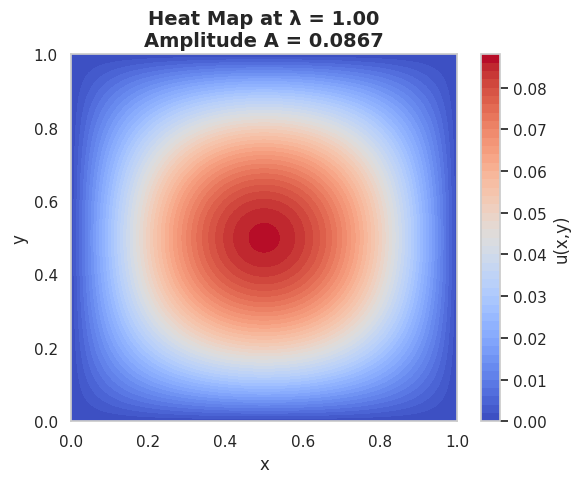

> Plot for Solution 2


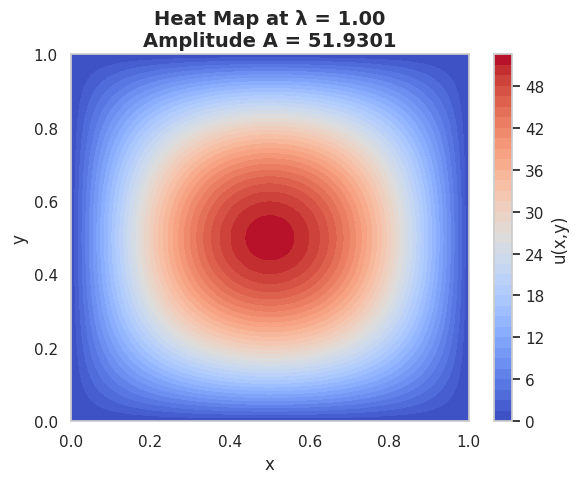

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
PI2 = np.pi**2

def solve_for_amplitude(lam):
    """
    Solve for the positive amplitude(s) A in the separable ansatz:
      u(x,y) = A * sin(πx) * sin(πy)
    using a third-order Taylor expansion for e^u.

    The reduced equation is:
      a2 * A^2 + a1 * A + a0 = 0,
    where
      a2 = lam * 8 / (9 * PI2),
      a1 = lam / 4 - PI2 / 2,
      a0 = lam * 4 / PI2.

    Returns a sorted list of positive amplitudes.
    """
    a2 = lam * 8 / (9 * PI2)
    a1 = lam / 4 - PI2 / 2
    a0 = lam * 4 / PI2
    disc = a1**2 - 4 * a2 * a0
    if disc < 0:
        return []
    sqrt_disc = np.sqrt(disc)
    root1 = (-a1 + sqrt_disc) / (2 * a2)
    root2 = (-a1 - sqrt_disc) / (2 * a2)
    return sorted([r for r in (root1, root2) if r > 1e-9])

def calculate_jacobian_determinant(lam, A):
    """
    Compute the reduced Jacobian determinant:
      detJ = lam*(1/4 + 16*A/(9*PI2)) - PI2/2.
    """
    return lam * (1/4 + 16*A/(9*PI2)) - PI2/2

def u_approx(x, y, A):
    """Compute u(x,y) = A*sin(πx)*sin(πy)."""
    return A * np.sin(np.pi * x) * np.sin(np.pi * y)

def plot_approx_solution(lam=1.0, solution_index=0, cmap='coolwarm'):
    """
    Plot a 2D heat map of the approximate solution u(x,y) for a given λ.
    """
    roots = solve_for_amplitude(lam)
    if not roots:
        print(f"No positive amplitude found for λ = {lam:.2f}.")
        return
    try:
        A = roots[solution_index]
    except IndexError:
        print("Solution index out of range.")
        return
    nx, ny = 200, 200
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    U = u_approx(X, Y, A)
    plt.figure(figsize=(6, 5))
    cf = plt.contourf(X, Y, U, levels=50, cmap=cmap)
    plt.colorbar(cf, label="u(x,y)")
    plt.title(f"Heat Map at λ = {lam:.2f}\nAmplitude A = {A:.4f}", fontsize=14, fontweight='bold')
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.tight_layout()
    plt.show()

# Part 1: Solve for λ = 1 and display results
lam_fixed = 1.0
solutions = solve_for_amplitude(lam_fixed)

print("--- Solving for λ = 1 ---")
if solutions:
    for i, A in enumerate(solutions):
        print(f"Solution {i+1}: Amplitude A = {A:.4f}")
        print(f"  Corresponding to u(x,y) = {A:.4f} * sin(πx) * sin(πy)")
else:
    print("No positive amplitude solution found for λ = 1.")
print("-" * 30 + "\n")

print("Displaying Part 1 plots:")
for i in range(len(solutions)):
    print(f"> Plot for Solution {i+1}")
    plot_approx_solution(lam_fixed, solution_index=i, cmap='coolwarm')


# Part 1: Separable‑Ansatz Solution for **λ = 1**

In this section, we analyze a snapshot of the 2D Bratu problem by fixing the parameter value at **λ = 1**.

We assume a separable solution of the form:

$$
u(x,y) = A \sin(\pi x) \sin(\pi y)
$$

and use a third-order Taylor expansion for \(e^u\):

$$
e^u \approx 1 + u + \frac{u^2}{2} + \frac{u^3}{6}.
$$

This approximation leads to a reduced algebraic equation for the amplitude \(A\):

$$
a_2 A^2 + a_1 A + a_0 = 0,
$$

with coefficients

$$
a_2 = \frac{8 \lambda}{9 \pi^2}, \quad a_1 = \frac{\lambda}{4} - \frac{\pi^2}{2}, \quad a_0 = \frac{4 \lambda}{\pi^2}.
$$

Typically, this equation produces two positive solutions for \(A\), representing two solution branches (one often stable and one unstable). The code prints these amplitude values, then generates corresponding 2D heat maps illustrating the approximate spatial solution \(u(x,y)\) for each branch.

---

--- Performing Bifurcation Analysis ---


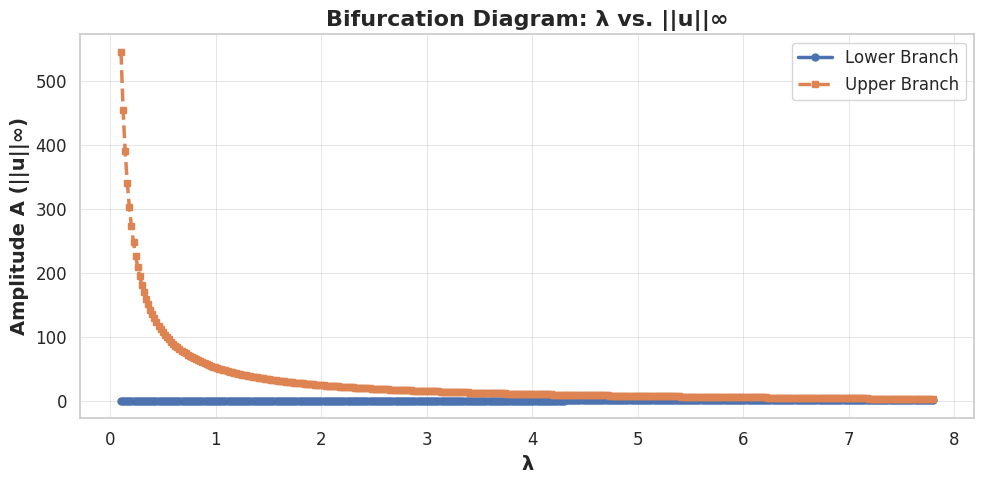

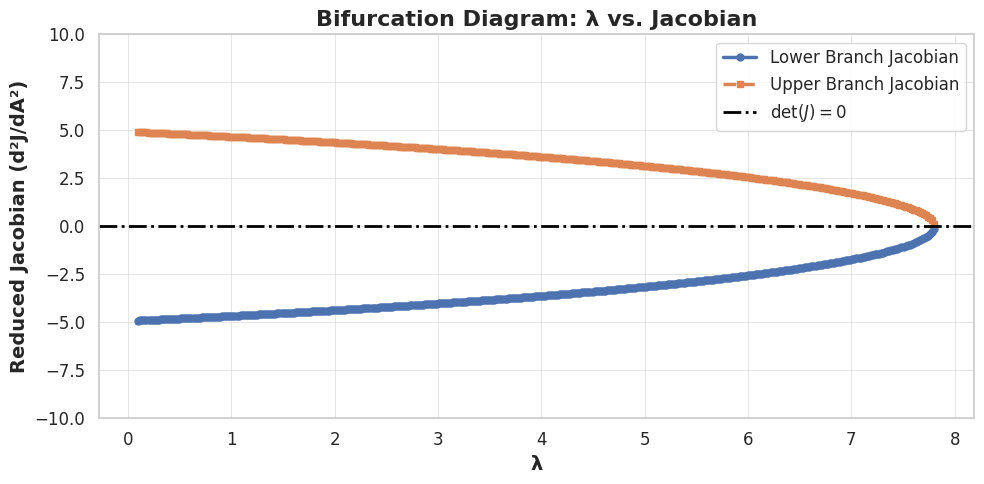

In [43]:
def perform_bifurcation_analysis(lam_min=0.1, lam_max=8.0, num_points=400):
    """
    Compute bifurcation data over a range of λ values.

    For each λ, compute the amplitude(s) from the separable ansatz and the reduced
    Jacobian determinant.

    Returns:
      tuple: (lambdas, A_branch1, A_branch2, detJ_branch1, detJ_branch2)
    """
    lambdas = np.linspace(lam_min, lam_max, num_points)
    A_branch1 = np.full_like(lambdas, np.nan)
    A_branch2 = np.full_like(lambdas, np.nan)
    detJ_branch1 = np.full_like(lambdas, np.nan)
    detJ_branch2 = np.full_like(lambdas, np.nan)

    for i, lam in enumerate(lambdas):
        roots = solve_for_amplitude(lam)
        if len(roots) >= 1:
            A_branch1[i] = roots[0]
            detJ_branch1[i] = calculate_jacobian_determinant(lam, roots[0])
        if len(roots) == 2:
            A_branch2[i] = roots[1]
            detJ_branch2[i] = calculate_jacobian_determinant(lam, roots[1])
    return lambdas, A_branch1, A_branch2, detJ_branch1, detJ_branch2

def plot_bifurcation():
    """
    Plot the bifurcation diagrams:
      1. λ vs. amplitude A.
      2. λ vs. reduced Jacobian.
    """
    lambdas, A_branch1, A_branch2, detJ_branch1, detJ_branch2 = perform_bifurcation_analysis()

    plt.figure(figsize=(10, 5))
    plt.plot(lambdas, A_branch1, label='Lower Branch', color='C0',
             linewidth=2.5, marker='o', markersize=5)
    plt.plot(lambdas, A_branch2, label='Upper Branch', color='C1', linestyle='--',
             linewidth=2.5, marker='s', markersize=5)
    plt.xlabel("λ", fontsize=14, fontweight='bold')
    plt.ylabel("Amplitude A (||u||∞)", fontsize=14, fontweight='bold')
    plt.title("Bifurcation Diagram: λ vs. ||u||∞", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(lambdas, detJ_branch1, label='Lower Branch Jacobian', color='C0',
             linewidth=2.5, marker='o', markersize=5)
    plt.plot(lambdas, detJ_branch2, label='Upper Branch Jacobian', color='C1', linestyle='--',
             linewidth=2.5, marker='s', markersize=5)
    plt.axhline(0, color='black', linestyle='-.', linewidth=2, label=r"$\det(J)=0$")
    plt.xlabel("λ", fontsize=14, fontweight='bold')
    plt.ylabel("Reduced Jacobian (d²J/dA²)", fontsize=14, fontweight='bold')
    plt.title("Bifurcation Diagram: λ vs. Jacobian", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
    plt.ylim(-10, 10)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

print("--- Performing Bifurcation Analysis ---")
plot_bifurcation()




# Part 2: Bifurcation Analysis

In this part, we explore the global behavior of the reduced Bratu model by varying the parameter **λ** over a prescribed range (e.g., from 0.1 to 8).

For each value of \( \lambda \), the following are computed:
- The amplitude \(A\) using the separable ansatz.
- The reduced Jacobian determinant, which in our model is given by

$$
\det(J) = \lambda \left( \frac{1}{4} + \frac{16 A}{9 \pi^2} \right) - \frac{\pi^2}{2}.
$$

A zero crossing in the Jacobian plot signals a turning (bifurcation) point.

Two bifurcation diagrams are generated:
- **$\lambda$ vs. Amplitude $A$ ($\|u\|_\infty$)**: This plot shows how the maximum norm of the solution changes with $\lambda$, revealing the turning point between branches.
- **$\lambda$ vs. Reduced Jacobian Determinant**: This plot highlights the change in stability of the branches, with a zero crossing of the Jacobian indicating a bifurcation.


Together, these analyses provide a comprehensive view of the behavior and stability of the solution branches as **$\lambda$** varies.

----
